# Generating text with RNN
Disclaimer: This notebook is an adopted version of [this](https://github.com/yandexdataschool/Practical_DL/blob/fall18/week06_rnn/seminar_pytorch.ipynb).

This time you'll find yourself delving into the heart of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead!

## Imports

In [1]:
from IPython.display import clear_output

import os
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

## Parameters

In [2]:
device = torch.device("cpu")#torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Data
The dataset contains ~8k earthling names from different cultures, all in latin transcript. This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

Let's read and explore our data. You can find it at `./data` dir. **Note:** all names in `names.txt` starts with space symbol ` `.

In [3]:
start_token = ' '

with open("data/names.txt") as fin:
    lines = fin.read()[:-1].split('\n')
    lines = [start_token + line for line in lines]

In [4]:
print ("# of samples = ",len(lines))
print()

for x in lines[::1000]:
    print(x)

# of samples =  7944

 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length =  16


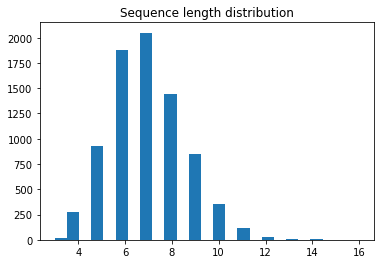

In [5]:
MAX_LENGTH = max(map(len, lines))
print("max length = ", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)), bins=25);

## Task 1 (1 point). Text preprocessing

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids:

In [6]:
# all unique characters go here
tokens = list(set(''.join(lines)))

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  55


In [7]:
token_to_id = {tokens[i] for i in range(len(tokens))}

### Convert characters to ids

Torch is built for crunching numbers, not strings. 
To train our neural network, we'll need to replace characters with their indices in tokens list. Let's compose a dictionary that does this mapping.

In [8]:
token_to_id = {tokens[i]: i for i in range(len(tokens))}

assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Now let's create function to convert list of **lines** into matrix of **ids**:

In [9]:
def to_matrix(lines, max_len=None, pad=token_to_id[' ']):
    """Casts a list of lines into id-matrix"""
    
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype='int32') + pad

    for n, line in enumerate(lines):
        for nsymb, symb in enumerate(line):
            lines_ix[n, nsymb] = token_to_id[symb]

    return lines_ix

In [10]:
print("Lines: ")
print('\n'.join(lines[::2000]))
print()
print("Corresponding matrix: ")
print(to_matrix(lines[::2000]))

Lines: 
 Abagael
 Glory
 Prissie
 Giovanne

Corresponding matrix: 
[[ 2 21 22 24 30 24 28 40  2]
 [ 2 18 40 31 12 15  2  2  2]
 [ 2  4 12 53 50 50 53 28  2]
 [ 2 18 53 31 27 24 23 23 28]]


## Task 2 (1 point). Vanilla RNN

We can rewrite RNN as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.

<img src="./static/rnn.png" width=480>

Since we're training a language model, there should also be:
* An embedding layer (see [nn.Embedding](https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding)) that converts character's id $x_t$ to a vector.
* An output layer that predicts probabilities of next character from current hidden state $h_{t+1}$

Let's implement this model in PyTorch:

In [12]:
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens, embedding_size=16, hidden_size=64):
        super().__init__()
        
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + hidden_size, hidden_size)
        self.logits = nn.Linear(hidden_size, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids
        :param h_prev: batch of previous RNN hidden states
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        h_next = self.rnn_update(torch.cat((h_prev, x_emb), dim=1))
        
        # compute logits for next character probs
        logits = self.logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """Return RNN state before it processes first input (a.k.a. h_0)"""
        return torch.zeros(batch_size, self.hidden_size)

In [13]:
char_rnn_cell = CharRNNCell(num_tokens)

Once we've defined a single RNN step, we can apply it in a loop to get predictions on each step:

In [14]:
def rnn_loop(cell, batch_ix):
    """
    Computes log P(next_character) for all time-steps in lines_ix
    :param lines_ix: an matrix of shape [batch, time], output of to_matrix(lines)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = cell.initial_state(batch_size)
    
    logprobs = []
    for x_t in batch_ix.transpose(0, 1):
        hid_state, logp_next = char_rnn_cell(x_t, hid_state)
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

Let's try it out:

In [15]:
batch_ix = to_matrix(lines[:5])
batch_ix = torch.LongTensor(batch_ix)

logp_seq = rnn_loop(char_rnn_cell, batch_ix)
print(logp_seq.shape)

torch.Size([5, 8, 55])


### Likelihood and gradients

We can now train our neural network to minimize crossentropy (maximize log-likelihood) with the actual next tokens.

To do so in a vectorized manner, we take `batch_ix[:, 1:]` - a matrix of token ids shifted i step to the left so i-th element is acutally the "next token" for i-th prediction

In [16]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

# here's a loss magic spell (what does this lines mean?)
logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:, :, None])
loss = -logp_next.mean()

loss.backward()

We train our char-rnn exactly the same way we train any deep learning model before. The only difference is that this time we sample lines, not images.

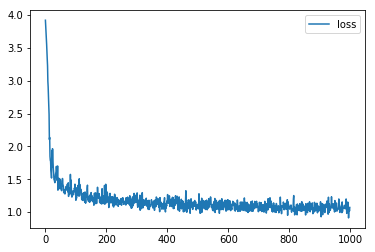

In [17]:
char_rnn_cell = CharRNNCell(num_tokens).to(device)
opt = torch.optim.Adam(char_rnn_cell.parameters())
history = []

for i in range(1000):
    batch_ix = to_matrix(random.sample(lines, 32), max_len=MAX_LENGTH)
    batch_ix = torch.from_numpy(batch_ix).type(torch.long).to(device)
    logp_seq = rnn_loop(char_rnn_cell, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:, :, None])
    loss = -logp_next.mean()
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # dump statistics
    history.append(loss.item())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

### Generating text
Once we've trained our network a bit, let's get to actually generating stuff. We trained a so-called **language model**. Mathematically our neural network models probability of the next character conditioned on previous characters:
$$
    RNN(w_{t-1}, ..., w_{1}) = P(w_t | w_{t-1}, ..., w_{1})
$$

If we want to generate new sequence with our language model, we feed some seed charactes to it and then greedily generate new characters. Below, you can find the implementation of the sampling function. Read and **understand** this code. After, answer the question:

**Q**: What is the purpose the parameter `temperature`? What happens if we increase/decrease it?

In [18]:
def generate_sample(cell, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length `max_length`.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence]).type(torch.long).to(device)

    hid_state = cell.initial_state(batch_size=1)
    
    # feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = cell(x_sequence[:, i], hid_state)
    
    # start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = cell(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).detach().cpu().numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]]).type(torch.long).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.detach().cpu().numpy()[0]])

Completely random names:

In [19]:
for _ in range(10):
    print(generate_sample(char_rnn_cell))

 Asa            
 Daonam         
 PanconiNa      
 Aviecha        
 Aluicgala      
 Kanion         
 Kuepthe        
 Mawlice        
 Lurier         
 Dandy          


Random names starting with seed phrase:

In [57]:
for _ in range(50):
    print(generate_sample(char_rnn_cell, seed_phrase=' Lol'))

 Lolep          
 Loloo          
 Lolvin         
 Lola           
 Lolle          
 Lolsiev        
 Lolnisr        
 Loleadde       
 Lollyle        
 Lolqha         
 Lolonise       
 Loltoe         
 Loll           
 Lolerta        
 Lolimert       
 Lolkea         
 Lole           
 Lolwmh         
 Lollib t       
 Lolene         
 Lollsa         
 Lolly          
 Lolce          
 Lolrka         
 Lolla          
 Lole           
 Lolrine        
 Lolone         
 Lolned         
 Lolla          
 Loleme         
 Lolitph        
 Loleye         
 Lolke          
 Lolee          
 Lole           
 Lolbie         
 Lolie          
 Lolyrila       
 Lolee          
 Lolle          
 Lolrarele      
 Lolice         
 Lolsa          
 Lollie         
 Lolyri         
 Lolfie         
 Lolale         
 Loliy          
 Lolane         


# Task 3 (2 points). LSTM
Before we used vanilla RNN cell to generate text, but there're [a lot of problems with it](https://towardsdatascience.com/lecture-evolution-from-vanilla-rnn-to-gru-lstms-58688f1da83a). Nowadays nobody uses vanilla RNN cells - everybody uses more pumped cells like [LSTM](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTMCell) or [GRU](https://pytorch.org/docs/stable/nn.html#torch.nn.GRUCell) cells. Here're some scary (at the first sight) images, explaining how LSTM works:

<img src="./static/lstm.png">

More details you can find in PyTorch docs: [LSTM](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTMCell) and [GRU](https://pytorch.org/docs/stable/nn.html#torch.nn.GRUCell).

**Task** will consist of 2 parts. Each task weights 1 point.

1. Implement CharRNN with 2-layered LSTM or GRU cell
2. Train your model on **your** text dataset (some ideas can be found below)

Ideas for datasets:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* RAP
* Source code of Linux or PyTorch
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* Ikea catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

In [63]:
start_token = ' '

with open("data/all_linux_utf8.c") as fin:
    clines = fin.read()[:-1].split('\n')
    clines = [start_token + line for line in clines]